In [68]:
# Step 1: Imports and Drive Mount
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn Imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Mount Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [69]:
# Step 2: Load Data
# CHANGE THIS PATH to match your actual file location in Google Drive
path = "/content/drive/MyDrive/binod ai/social_media_vs_productivity.csv"

try:
    df = pd.read_csv(path)
    print("File Loaded Successfully!")
    print("First 5 Rows:")
    print(df.head())
except FileNotFoundError:
    print("ERROR: File not found. Please check the path.")


File Loaded Successfully!
First 5 Rows:
   age  gender    job_type  daily_social_media_time  \
0   56    Male  Unemployed                 4.180940   
1   46    Male      Health                 3.249603   
2   32    Male     Finance                      NaN   
3   60  Female  Unemployed                      NaN   
4   25    Male          IT                      NaN   

  social_platform_preference  number_of_notifications  work_hours_per_day  \
0                   Facebook                       61            6.753558   
1                    Twitter                       59            9.169296   
2                    Twitter                       57            7.910952   
3                   Facebook                       59            6.355027   
4                   Telegram                       66            6.214096   

   perceived_productivity_score  actual_productivity_score  stress_level  \
0                      8.040464                   7.291555           4.0   
1             


Dataset Shape: (30000, 19)

Missing Values:
 age                                  0
gender                               0
job_type                             0
daily_social_media_time           2765
social_platform_preference           0
number_of_notifications              0
work_hours_per_day                   0
perceived_productivity_score      1614
actual_productivity_score         2365
stress_level                      1904
sleep_hours                       2598
screen_time_before_sleep          2211
breaks_during_work                   0
uses_focus_apps                      0
has_digital_wellbeing_enabled        0
coffee_consumption_per_day           0
days_feeling_burnout_per_month       0
weekly_offline_hours                 0
job_satisfaction_score            2730
dtype: int64

Statistical Summary:
                 age  daily_social_media_time  number_of_notifications  \
count  30000.000000             27235.000000             30000.000000   
mean      41.486867            

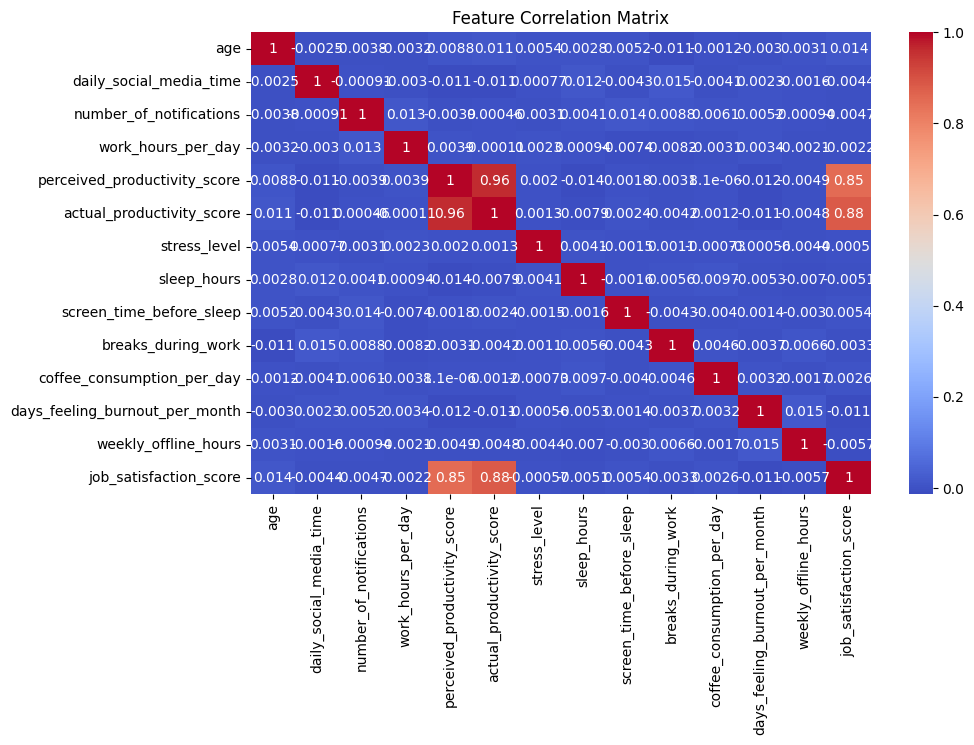

In [70]:
# Step 3: EDA
print("\nDataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe())

# Visualization: Correlation Matrix
plt.figure(figsize=(10, 6))
# Select only numeric columns for correlation
numeric_df = df.select_dtypes(include=[np.number])
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")
plt.show()


In [73]:
# Step 4: Preprocessing

# 1. Handle Missing Values (Drop rows with missing data)
df = df.dropna()

# 2. Encode Non-Numeric Columns (Text -> Numbers)
le = LabelEncoder()
for col in df.select_dtypes(include='object'):
    df[col] = le.fit_transform(df[col])

# 3. Define Target (y) and Features (X)
# CHECK: Ensure 'Productivity_Score' exists in your CSV
target_col = "actual_productivity_score" # Changed target column to 'actual_productivity_score'

X = df.drop(target_col, axis=1)
y = df[target_col]

# 4. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Scale Features (Standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data successfully processed and split.")

Data successfully processed and split.


In [74]:
# Step 5: Neural Network

mlp = MLPRegressor(
    hidden_layer_sizes=(64, 32),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)

# Function to Print Results
def evaluate_model(y_true, y_pred, name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n--- {name} ---")
    print(f"MAE  : {mae:.4f}")
    print(f"RMSE : {rmse:.4f}")
    print(f"R2   : {r2:.4f}")
    return [mae, rmse, r2]

mlp_metrics = evaluate_model(y_test, y_pred_mlp, "Neural Network")



--- Neural Network ---
MAE  : 0.4007
RMSE : 0.5017
R2   : 0.9312


In [75]:
# Step 6: Classical Models

# 1. Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# 2. Random Forest
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

lr_metrics = evaluate_model(y_test, y_pred_lr, "Linear Regression")
rf_metrics = evaluate_model(y_test, y_pred_rf, "Random Forest")



--- Linear Regression ---
MAE  : 0.3568
RMSE : 0.4464
R2   : 0.9456

--- Random Forest ---
MAE  : 0.3640
RMSE : 0.4573
R2   : 0.9429


In [76]:
# Step 7: Optimization & Selection

# --- Hyperparameter Tuning (Grid Search) ---
print("\nRunning Grid Search...")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3
)
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print("Best Parameters Found:", grid_search.best_params_)

# --- Feature Selection (RFE) ---
print("\nRunning Feature Selection...")
# Select top 3 features (Change 3 to whatever number you prefer)
selector = RFE(estimator=LinearRegression(), n_features_to_select=3)
selector.fit(X_train, y_train)

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)

print("Feature Selection Complete.")



Running Grid Search...
Best Parameters Found: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Running Feature Selection...
Feature Selection Complete.


In [77]:
# Step 8: Final Comparison

# 1. Final Optimized Random Forest
best_rf.fit(X_train_sel, y_train)
y_pred_final_rf = best_rf.predict(X_test_sel)
final_rf_metrics = evaluate_model(y_test, y_pred_final_rf, "Optimized Random Forest")

# 2. Final Linear Regression
lr_final = LinearRegression()
lr_final.fit(X_train_sel, y_train)
y_pred_final_lr = lr_final.predict(X_test_sel)
final_lr_metrics = evaluate_model(y_test, y_pred_final_lr, "Final Linear Regression")

# 3. Final Neural Network
mlp_final = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42)
mlp_final.fit(X_train_sel, y_train)
y_pred_final_mlp = mlp_final.predict(X_test_sel)
final_mlp_metrics = evaluate_model(y_test, y_pred_final_mlp, "Final Neural Network")

# Create Comparison Table
results_df = pd.DataFrame({
    "Model": ["Random Forest", "Linear Regression", "Neural Network"],
    "MAE": [final_rf_metrics[0], final_lr_metrics[0], final_mlp_metrics[0]],
    "RMSE": [final_rf_metrics[1], final_lr_metrics[1], final_mlp_metrics[1]],
    "R2 Score": [final_rf_metrics[2], final_lr_metrics[2], final_mlp_metrics[2]]
})

print("\n=== FINAL COMPARISON TABLE ===")
print(results_df)



--- Optimized Random Forest ---
MAE  : 0.3636
RMSE : 0.4565
R2   : 0.9431

--- Final Linear Regression ---
MAE  : 0.3567
RMSE : 0.4462
R2   : 0.9456

--- Final Neural Network ---
MAE  : 0.3591
RMSE : 0.4495
R2   : 0.9448

=== FINAL COMPARISON TABLE ===
               Model       MAE      RMSE  R2 Score
0      Random Forest  0.363637  0.456528  0.943057
1  Linear Regression  0.356706  0.446183  0.945608
2     Neural Network  0.359089  0.449472  0.944803


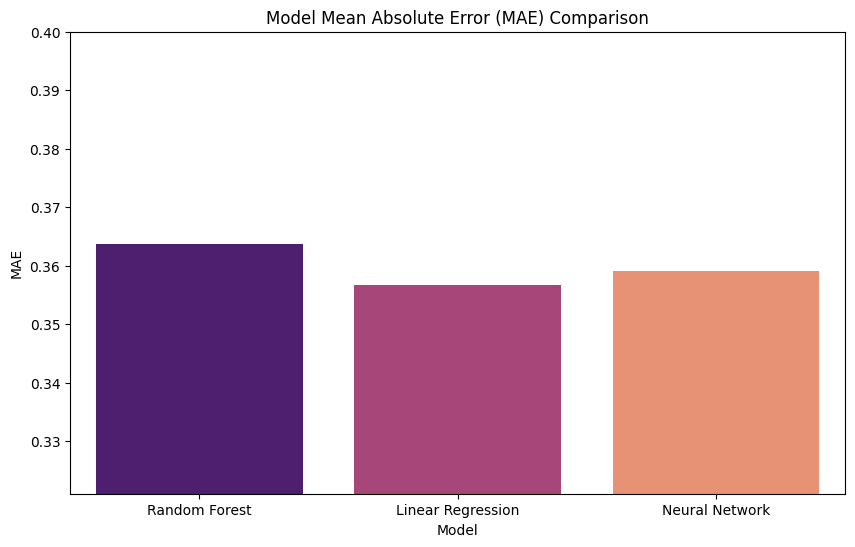

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize MAE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='MAE', data=results_df, palette='magma')
plt.title('Model Mean Absolute Error (MAE) Comparison')
plt.ylabel('MAE')
plt.ylim(results_df['MAE'].min() * 0.9, results_df['MAE'].max() * 1.1) # Adjust y-lim for better visualization
plt.show()


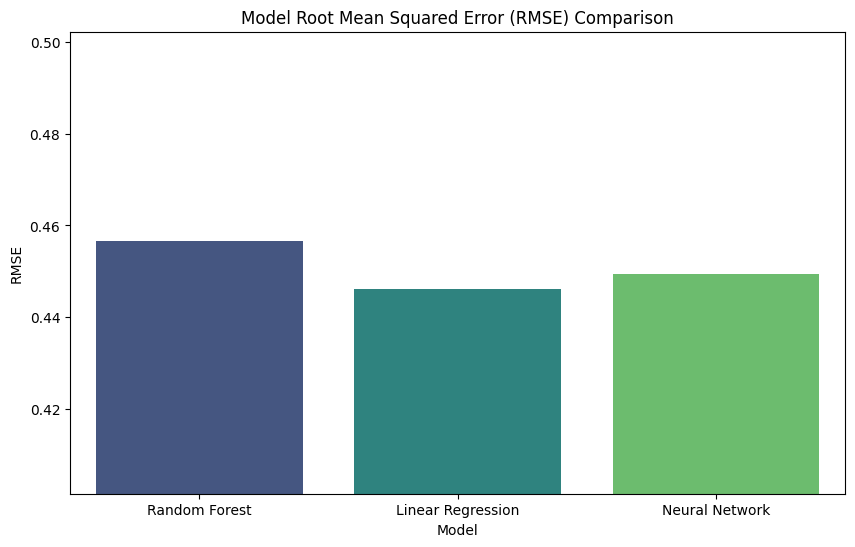

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize RMSE Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='viridis')
plt.title('Model Root Mean Squared Error (RMSE) Comparison')
plt.ylabel('RMSE')
plt.ylim(results_df['RMSE'].min() * 0.9, results_df['RMSE'].max() * 1.1) # Adjust y-lim for better visualization
plt.show()


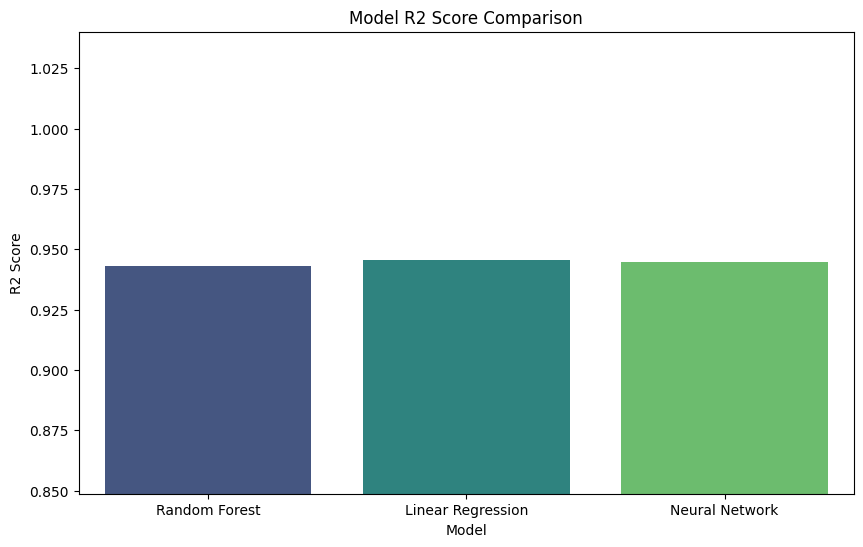

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize R2 Score Comparison
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R2 Score', data=results_df, palette='viridis')
plt.title('Model R2 Score Comparison')
plt.ylabel('R2 Score')
plt.ylim(results_df['R2 Score'].min() * 0.9, results_df['R2 Score'].max() * 1.1) # Adjust y-lim for better visualization
plt.show()


### Final Model Performance Table

In [79]:
display(results_df)


,Model,MAE,RMSE,R2 Score
0,Random Forest,0.363637,0.456528,0.943057
1,Linear Regression,0.356706,0.446183,0.945608
2,Neural Network,0.359089,0.449472,0.944803
